In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%cd ..

/home/rainorangelemon/Documents/tiny-diffusion


/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [17]:
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import torch as th
from scripts.best_of_n_on_sam_dataset import create_model_and_diffusion, CLEVRPosDataset, conditions_denoise_fn_factory, make_estimate_neg_logp
from pathlib import Path
import numpy as np
from PIL import Image

In [23]:
with initialize(config_path="../conf", version_base="1.1"):
    cfg = compose(config_name="clevr_pos",
                  overrides=["method_name=notebook-logp",
                             "num_constraints=5",
                             "ckpt_path=ComposableDiff/models/ema_runpod_780000.pt",
                             "model.noise_schedule=linear",
                            ])

In [24]:
# Setup
th.set_float32_matmul_precision('high')
th.set_grad_enabled(False)
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

options = OmegaConf.to_container(cfg.model, resolve=True)

options["use_fp16"] = th.cuda.is_available()

model, diffusion = create_model_and_diffusion(**options)

model.eval()
if options['use_fp16']:
    model.convert_to_fp16()
model.to(device)

print(f'Loading checkpoint from {cfg.ckpt_path}')
checkpoint = th.load(cfg.ckpt_path, map_location='cpu')
model.load_state_dict(checkpoint)

print('Total base parameters', sum(x.numel() for x in model.parameters()))

# Create output directory
output_dir = Path(cfg.output_dir)
experiment_name = cfg.data_path.split('/')[-1].split('.')[0]
output_dir = output_dir / experiment_name
output_dir.mkdir(parents=True, exist_ok=True)

# Save the config
config_save_path = os.path.join(cfg.output_dir, "config.yaml")
with open(config_save_path, "w") as f:
    f.write(OmegaConf.to_yaml(cfg))

dataset = CLEVRPosDataset(data_path=cfg.data_path)

Loading checkpoint from ComposableDiff/models/ema_runpod_780000.pt
Total base parameters 224779782


In [25]:
from scripts.best_of_n_on_sam_dataset import add_noise_at_t, remove_noise_to_t

condition_idx = 1
test_idx = 1
positive_ims = [np.array(Image.open(f"runs/10-21_17-39-55/test_clevr_pos_5000_5/original_sample_{test_idx:05d}_{i:05d}.png").convert("RGB")) for i in [3, 6, 20, 31, 45, 46, 69, 76, 77, 82]]
negative_ims = [np.array(Image.open(f"runs/10-21_17-39-55/test_clevr_pos_5000_5/original_sample_{test_idx:05d}_{i:05d}.png").convert("RGB")) for i in [81, 83, 53, 29, 16, 13, 11, 00, 74, 47]]
labels, _ = dataset[test_idx]

conditions_denoise_fn = conditions_denoise_fn_factory(model, th.tensor(labels[np.newaxis], dtype=th.float32),
                                                        batch_size=cfg.mini_batch, cfg=cfg)
estimate_neg_logp = make_estimate_neg_logp(elbo_cfg=cfg.elbo,
                                                        noise_scheduler=diffusion,
                                                        unconditioned_denoise_fn=conditions_denoise_fn[-1],
                                                        mini_batch=cfg.mini_batch,
                                                        progress=True)


all_samples = th.from_numpy(np.stack(positive_ims + negative_ims)).to(device).permute(0, 3, 1, 2).float()
# normalize the images
all_samples = (all_samples / 255.0) * 2.0 - 1.0

# set the region around label to 0
coord = labels[condition_idx]
coord = coord.copy()
coord[0] = coord[0] * 128
coord[1] = (1 - coord[1]) * 128
coord = coord.astype(np.int32)


def predict_noise(all_samples, noise, timesteps_t, k):
    timesteps_k = th.full((len(all_samples),), k, dtype=th.long, device=all_samples.device)
    noisy_x = add_noise_at_t(diffusion.base_diffusion, all_samples, noise, timesteps_t, timesteps_k)

        # check the predicted x0
    pred = conditions_denoise_fn[condition_idx](noisy_x, timesteps_k)
    predicted_noise = pred[:, :3]
    model_var_values = pred[:, 3:]

        # get the variance of the predicted noise
    min_log = diffusion.base_diffusion.posterior_log_variance_clipped[k]
    max_log = np.log(diffusion.base_diffusion.betas)[k]
        # The model_var_values is [-1, 1] for [min_var, max_var].
    frac = (model_var_values + 1) / 2
    model_log_variance = frac * max_log + (1 - frac) * min_log
    model_variance = th.exp(model_log_variance)

    x0 = remove_noise_to_t(diffusion.base_diffusion, noisy_x, predicted_noise, timesteps_t, timesteps_k)

    pred_uncond = conditions_denoise_fn[-1](noisy_x, timesteps_k)
    predicted_noise_uncond = pred_uncond[:, :3]
    model_var_values_uncond = pred_uncond[:, 3:]

    frac_uncond = (model_var_values_uncond + 1) / 2
    model_log_variance_uncond = frac_uncond * max_log + (1 - frac_uncond) * min_log
    model_variance_uncond = th.exp(model_log_variance_uncond)

    x0_uncond = remove_noise_to_t(diffusion.base_diffusion, noisy_x, predicted_noise_uncond, timesteps_t, timesteps_k)
    return predicted_noise, model_variance, predicted_noise_uncond, model_variance_uncond

In [26]:
# generate normal images
import baselines_clevr
from torchvision.utils import make_grid, save_image
th.manual_seed(0)
th.cuda.manual_seed(0)

single_conditioned_samples = \
baselines_clevr.diffusion_baseline(lambda x, t: conditions_denoise_fn[condition_idx](x, t, use_cfg=False),
                                   diffusion,
                                   x_shape=(3, 128, 128),
                                   eval_batch_size=10)[-1]
single_conditioned_samples = th.clamp(single_conditioned_samples, -1, 1)
single_conditioned_samples = single_conditioned_samples.to(device)
single_conditioned_samples_to_render = 0.5 * single_conditioned_samples + 0.5
make_grid(single_conditioned_samples_to_render, nrow=10).permute(1, 2, 0).cpu().numpy()
# save the images
save_image(single_conditioned_samples_to_render, output_dir / f"single_conditioned_samples.png")

100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


In [27]:
single_conditioned_samples_neg = \
baselines_clevr.diffusion_baseline(lambda x, t: conditions_denoise_fn[condition_idx+3](x, t, use_cfg=False),
                                   diffusion,
                                   x_shape=(3, 128, 128),
                                   eval_batch_size=10)[-1]
single_conditioned_samples_neg = th.clamp(single_conditioned_samples_neg, -1, 1)
single_conditioned_samples_neg = single_conditioned_samples_neg.to(device)
single_conditioned_samples_to_render = 0.5 * single_conditioned_samples_neg + 0.5
make_grid(single_conditioned_samples_to_render, nrow=10).permute(1, 2, 0).cpu().numpy()
# save the images
save_image(single_conditioned_samples_to_render, output_dir / f"single_conditioned_samples_neg.png")

100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


In [10]:
all_samples_single = th.cat([single_conditioned_samples, single_conditioned_samples_neg], dim=0)

In [12]:
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
import wandb


# run = wandb.init(project="analyze_logp",
#                  name=f"{cfg.experiment_name}",
#                  config=OmegaConf.to_container(cfg, resolve=True),
#                  entity="rainorangelemon")

packed_l2_distance_diff = th.zeros((len(all_samples), 10, 1000), device=all_samples.device)
packed_l2_distance_diff_for_single = th.zeros((len(all_samples_single), 10, 1000), device=all_samples.device)

for seed in range(3):

        th.manual_seed(seed)
        th.cuda.manual_seed(seed)
        noise = th.randn_like(all_samples[0, ...], device=all_samples.device)[None, ...]#.expand(len(all_samples), -1, -1, -1)
        timesteps_t = th.full((len(all_samples),), 0, dtype=th.long, device=all_samples.device)


        for k in tqdm(range(1000)):
                predicted_noise, model_variance, predicted_noise_uncond, model_variance_uncond = predict_noise(all_samples, noise, timesteps_t, k)

                # get the L2 distance
                l2_distance = ((predicted_noise - noise).pow(2) / model_variance).sum(dim=(1, 2, 3))
                cosine_distance = th.nn.functional.cosine_similarity(predicted_noise.flatten(1), noise.flatten(1), dim=1)

                l2_distance_uncond = ((predicted_noise_uncond - noise).pow(2) / model_variance_uncond).sum(dim=(1, 2, 3))
                cosine_distance_uncond = th.nn.functional.cosine_similarity(predicted_noise_uncond.flatten(1), noise.flatten(1), dim=1)

                l2_distance_diff = l2_distance - l2_distance_uncond
                cosine_distance_diff = cosine_distance - cosine_distance_uncond

                packed_l2_distance_diff[:, seed, k] = l2_distance_diff

                l2_distance_diff_cfg = l2_distance_uncond + (cfg.cfg_weight - 1) * l2_distance_diff
                cosine_distance_diff_cfg = cosine_distance_uncond + (cfg.cfg_weight - 1) * cosine_distance_diff

                # get the L2 distance for the single conditioned samples
                predicted_noise_single, model_variance_single, predict_noise_uncond_single, model_variance_uncond_single = \
                        predict_noise(all_samples_single, noise, timesteps_t[:len(all_samples_single)], k)
                l2_distance_single = ((predicted_noise_single - noise).pow(2) / model_variance_single).sum(dim=(1, 2, 3))
                l2_distance_uncond_single = ((predict_noise_uncond_single - noise).pow(2) / model_variance_uncond_single).sum(dim=(1, 2, 3))
                l2_distance_diff_single = l2_distance_single - l2_distance_uncond_single
                packed_l2_distance_diff_for_single[:, seed, k] = l2_distance_diff_single

                # use scikit to calculate the auc
                labels = [1] * len(positive_ims) + [0] * len(negative_ims)
                auc = roc_auc_score(labels, -l2_distance.cpu().numpy())
                auc_cosine = roc_auc_score(labels, cosine_distance.cpu().numpy())

                auc_uncond = roc_auc_score(labels, -l2_distance_uncond.cpu().numpy())
                auc_cosine_uncond = roc_auc_score(labels, cosine_distance_uncond.cpu().numpy())

                auc_diff = roc_auc_score(labels, -l2_distance_diff.cpu().numpy())
                auc_cosine_diff = roc_auc_score(labels, cosine_distance_diff.cpu().numpy())

                auc_diff_cfg = roc_auc_score(labels, -l2_distance_diff_cfg.cpu().numpy())
                auc_cosine_diff_cfg = roc_auc_score(labels, cosine_distance_diff_cfg.cpu().numpy())

                # # log to wandb
                # wandb.log({
                #         f"auc/{seed}": auc,
                #         f"auc_cosine/{seed}": auc_cosine,
                #         f"auc_uncond/{seed}": auc_uncond,
                #         f"auc_cosine_uncond/{seed}": auc_cosine_uncond,
                #         f"auc_diff/{seed}": auc_diff,
                #         f"auc_cosine_diff/{seed}": auc_cosine_diff,
                #         f"auc_diff_cfg/{seed}": auc_diff_cfg,
                #         f"auc_cosine_diff_cfg/{seed}": auc_cosine_diff_cfg,
                #         })

                # # save energy to pt file
                # th.save({"l2_distance": l2_distance,
                #         "cosine_distance": cosine_distance,
                #         "l2_distance_uncond": l2_distance_uncond,
                #         "cosine_distance_uncond": cosine_distance_uncond,
                #         }, output_dir / f"energy_seed_{seed:05d}_timestep_{k:05d}.pt")

100%|██████████| 1000/1000 [09:18<00:00,  1.79it/s]


In [13]:
packed_l2_distance_diff_for_single_origin = packed_l2_distance_diff_for_single.clone()
packed_l2_distance_diff_origin = packed_l2_distance_diff.clone()

In [14]:
packed_l2_distance_diff_for_single = packed_l2_distance_diff_for_single_origin.mean(dim=1)
packed_l2_distance_diff = packed_l2_distance_diff_origin.mean(dim=1)

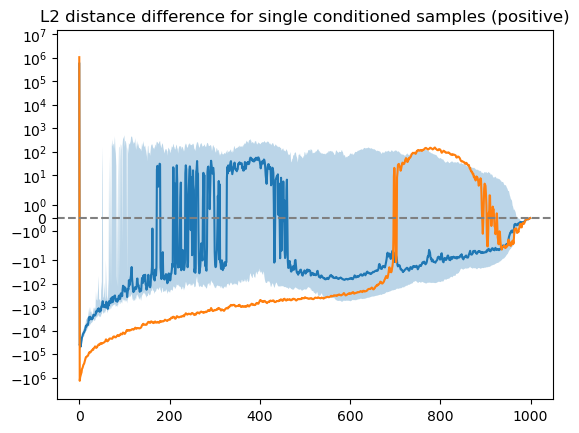

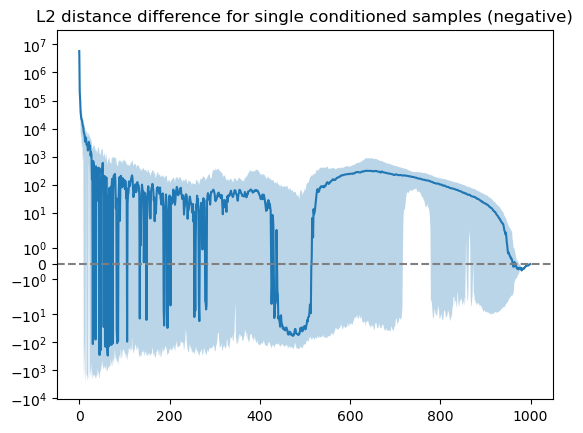

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot (packed_l2_distance_diff_for_single).max()
plt.clf()
plt.close("all")
plt.plot(packed_l2_distance_diff_for_single[:10].mean(dim=0).cpu().numpy())
# also plot the deviation band
plt.fill_between(range(1000), packed_l2_distance_diff_for_single[:10].max(dim=0)[0].cpu().numpy(), packed_l2_distance_diff_for_single[:10].min(dim=0)[0].cpu().numpy(), alpha=0.3)
plt.plot(packed_l2_distance_diff[:10].mean(dim=0).cpu().numpy())
# symmetric log
plt.yscale("symlog")
plt.axhline(0, color='gray', linestyle='--')
plt.title("L2 distance difference for single conditioned samples (positive)")
plt.show()

import matplotlib.pyplot as plt
# plot (packed_l2_distance_diff_for_single).max()
plt.clf()
plt.close("all")
plt.plot(packed_l2_distance_diff_for_single[10:].mean(dim=0).cpu().numpy())
# also plot the deviation band
plt.fill_between(range(1000), packed_l2_distance_diff_for_single[10:].max(dim=0)[0].cpu().numpy(), packed_l2_distance_diff_for_single[10:].min(dim=0)[0].cpu().numpy(), alpha=0.3)
# symmetric log
plt.yscale("symlog")
plt.axhline(0, color='gray', linestyle='--')
plt.title("L2 distance difference for single conditioned samples (negative)")
plt.show()

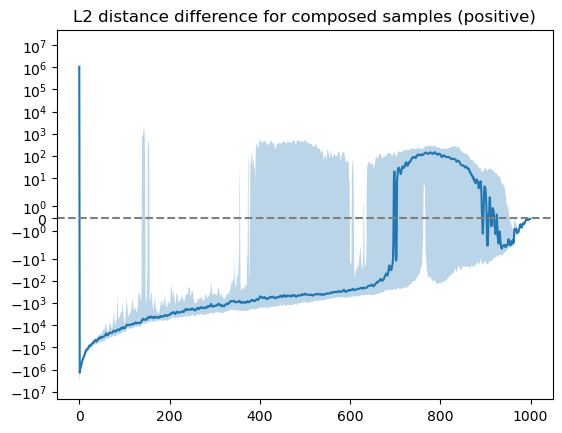

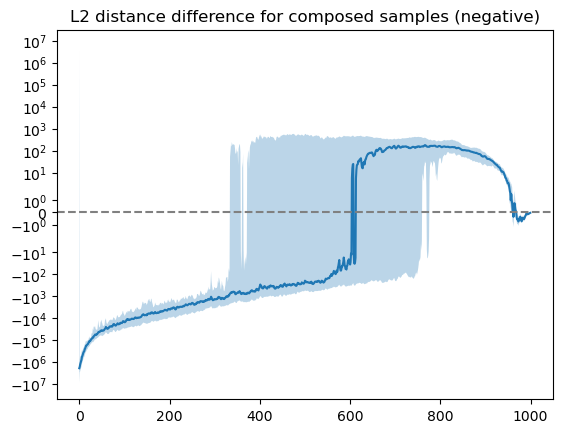

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.clf()
plt.close("all")
plt.plot(packed_l2_distance_diff[:10].mean(dim=0).cpu().numpy())
# also plot the deviation band
plt.fill_between(range(1000), packed_l2_distance_diff[:10].max(dim=0)[0].cpu().numpy(), packed_l2_distance_diff[:10].min(dim=0)[0].cpu().numpy(), alpha=0.3)
# symmetric log
plt.yscale("symlog")
plt.axhline(0, color='gray', linestyle='--')
plt.title("L2 distance difference for composed samples (positive)")
plt.show()


import matplotlib.pyplot as plt
plt.clf()
plt.close("all")
plt.plot(packed_l2_distance_diff[10:].mean(dim=0).cpu().numpy())
# also plot the deviation band
plt.fill_between(range(1000), packed_l2_distance_diff[10:].max(dim=0)[0].cpu().numpy(), packed_l2_distance_diff[10:].min(dim=0)[0].cpu().numpy(), alpha=0.3)
# symmetric log
plt.yscale("symlog")
plt.axhline(0, color='gray', linestyle='--')
plt.title("L2 distance difference for composed samples (negative)")
plt.show()